# Predicción de lluvia en Australia con Apache Spark

# 0. Carga de datos

In [2]:
import pandas as pd

#Los datos se han subido a la parte de archivos de manera manual
datos= pd.read_csv('Weather_Data.csv')

In [4]:
datos.shape

(93072, 23)

In [5]:
datos.head(5)

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0


In [6]:
datos.dtypes #Para conocer de que tipo es cada variable

row ID            object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow     float64
dtype: object

In [8]:
# Contar el número de valores nulos en cada columna
nulos_por_columna = datos.isnull().sum()

# Mostrar el número de valores nulos por columna
print("Número de valores nulos por columna:")
print(nulos_por_columna)
total_nulos = nulos_por_columna.sum()
("Número total de valores nulos en el DataFrame:", total_nulos)


Número de valores nulos por columna:
row ID               0
Location             0
MinTemp            406
MaxTemp            215
Rainfall           948
Evaporation      41226
Sunshine         44835
WindGustDir       6421
WindGustSpeed     6383
WindDir9am        6755
WindDir3pm        2614
WindSpeed9am       912
WindSpeed3pm      1811
Humidity9am       1177
Humidity3pm       1944
Pressure9am       9742
Pressure3pm       9726
Cloud9am         36476
Cloud3pm         38477
Temp9am            586
Temp3pm           1412
RainToday          948
RainTomorrow         1
dtype: int64


('Número total de valores nulos en el DataFrame:', 213015)

Evaporation, Sunshine, Cloud9am y Cloud3pm tienen muchos valores ausentes, podríamos pensar en eliminar estas columnas. Sin embargo, trabajaremos con ellas ya que pueden ser de interés en el estudio.

# 1. Sobre la base de datos

Australia Weather Data es una base de datos en la que se busca predecir si va a llover en diferentes zonas de Australia al día siguiente. Esta información, sobre si lloverá o no viene recogida en la variable RainTomorrow.

El dataset contiene 10 años de observacioens diarias sobre la precipitación en diferentes regiones de Australia. Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

En los datos de entrenamiento contamos con 99516 observaciones, mientras que en los datos de test contamos con 42677 observaciones. Respecto a las variables, son 23 para los datos de entrenamiento y 22 de los datos de test, la única diferencia es que se añade la variable RainTomorrow en los datos de entrenamiento. Las variables vienen explicadas a continuación:

<p style="text-align: justify;"></p>
<pre>
<strong>Location<strong> - Nombre de la ciudad de Australia donde se recogen los datos.
<strong>MinTemp<strong> - Temperatura minima en un día particular. (grados Celsius)
<strong>MaxTemp<strong> - Temperatura máxima en un día particular. (grados Celsius)
<strong>Rainfall<strong> - Precipitación de un día particualr. (milimetros)
<strong>Evaporation<strong> - Evaporación durante un día particular. (milimetros)
<strong>Sunshine<strong> - Brillo solar durante un día particular. (horas)
<strong>WindGusDir<strong> - La dirección de la ráfaga de viento más fuerte durante un día particular. (16 puntos de brujula posibles)
<strong>WindGuSpeed<strong> - Velocidad de la ráfaga de viendo más fuerte en un día particular. (kilometros ppr hora)
<strong>WindDir9am<strong> - La dirección del viento 10 minutos antes a las 9 de la mañana. (puntos de brújula)
<strong>WindDir3pm<strong> - La dirección del viento 10 minutos antes de las 3 p.m. (puntos de brújula)
<strong>WindSpeed9am<strong> - Velocidad del viento 10 minutos antes de las 9a.m. (kilometros por hora)
<strong>WindSpeed3pm<strong> - Velocidad del viento 10 minutos antes de las 3 p.m.(kilometros por hora)
<strong>Humidity9am<strong> - La humedad del viento a las 9 a.m. (%)
<strong>Humidity3pm<strong> - La humedad del viento a las 3 p.m. (%)
<strong>Pressure9am<strong> - Presión atmosférica a las 9 a.m. (hectopascales)
<strong>Pressure3pm<strong> - Presión atmosférica a las 3 p.m. (hectopascales)
<strong>Cloud9am<strong> -Las porciones del cielo cubiertas de nubes a las 9 a.m. (octavos)
<strong>Cloud3pm<strong> - Las porciones del cielo cubiertas de nubes a las 3 p.m. (octavos)
<strong>Temp9am<strong> - La temperatura a las 9 a.m. (grados Celsius)
<strong>Temp3pm<strong> - La temperatura a las 3 p.m. (grados Celsius)
<strong>RainToday<strong> - Si hoy llueve entonces ‘Si’. Si no llueve entonces ‘No’.
<strong>RainTomorrow<strong> - Si mañana llueve entonces 1 (Sí).Si no llueve entonces 0 (No).
</pre>


In [9]:
#Creamos el ambiente de trabajo de pyspark
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9ef96a8ba43ddbb9a05fc06df0dc79a2744edba61211c285c254edb8d8a0fc9c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [101]:
#Cargamos los paquetes necesarios para llevar a cabo nuestro estudio
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml import Pipeline
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

import random

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,DecisionTreeClassifier,GBTClassifier

In [11]:
# Visualizacion de los datos
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
# Fijamos una semilla aleatoria para la reproducibilidad de la libreta.
rnd_seed= 8
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# 2. Creación de la sesión de Spark.

In [13]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
appname = "Precipitaciones en Australia"

# Se obtiene la sesión por si estuviera abierta previamente y se cierra
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

spark

In [14]:
#Configuración de un entorno para poder ejecutar consultas SQL en tus datos de Spark
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [15]:
Data = "/content/Weather_Data.csv"
print(Data)

/content/Weather_Data.csv


Especificamos el esquema de nuestro dataset en spark según la naturaleza vista con numpy.

In [17]:
schema = StructType([
    StructField("RowID", StringType(),nullable=True),
    StructField("Location", StringType(), nullable=True), #1
    StructField("MinTemp", FloatType(), nullable=True),
    StructField("MaxTemp", FloatType(), nullable=True),
    StructField("Rainfall", FloatType(), nullable=True),
    StructField("Evaporation", FloatType(), nullable=True),
    StructField("Sunshine", FloatType(), nullable=True),
    StructField("WindGusdir", StringType(), nullable=True),
    StructField("WindGuSpeed", FloatType(), nullable=True),
    StructField("WindDir9am", StringType(), nullable=True),
    StructField("WindDir3pm", StringType(), nullable=True), #10
    StructField("WindSpeed9am", FloatType(), nullable=True),
    StructField("WindSpeed3pmm", FloatType(), nullable=True),
    StructField("Humidity9am", FloatType(), nullable=True),
    StructField("Humidity3pm", FloatType(), nullable=True),
    StructField("Preasure9am", FloatType(), nullable=True),
    StructField("Preasure3pm", FloatType(), nullable=True),
    StructField("Cloud9am", FloatType(), nullable=True),
    StructField("Cloud3pm", FloatType(), nullable=True),
    StructField("Temp9am", FloatType(), nullable=True),
    StructField("Temp3pm", FloatType(), nullable=True), #20
    StructField("RainToday", StringType(), nullable=True),
    StructField("RainTomorrow", IntegerType(), nullable=True)
    ]
)

In [19]:
# Cargamos los datos
df = spark.read.csv(path=Data, schema=schema, header = True).cache()

In [20]:
# Comprobamos que esten bien codificados.
df.show(5)

+-----+--------+-------+-------+--------+-----------+--------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|RowID|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGusdir|WindGuSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pmm|Humidity9am|Humidity3pm|Preasure9am|Preasure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-----+--------+-------+-------+--------+-----------+--------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
| Row0|  Albury|   13.4|   22.9|     0.6|       NULL|    NULL|         W|       44.0|         W|       WNW|        20.0|         24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|    NULL|   16.9|   21.8|       No|           0|
| Row1|  Albury|    7.4|   25.1|     0.0

In [21]:
# Las primeras 5 lineas de forma menos visual
df.take(5)

[Row(RowID='Row0', Location='Albury', MinTemp=13.399999618530273, MaxTemp=22.899999618530273, Rainfall=0.6000000238418579, Evaporation=None, Sunshine=None, WindGusdir='W', WindGuSpeed=44.0, WindDir9am='W', WindDir3pm='WNW', WindSpeed9am=20.0, WindSpeed3pmm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Preasure9am=1007.7000122070312, Preasure3pm=1007.0999755859375, Cloud9am=8.0, Cloud3pm=None, Temp9am=16.899999618530273, Temp3pm=21.799999237060547, RainToday='No', RainTomorrow=0),
 Row(RowID='Row1', Location='Albury', MinTemp=7.400000095367432, MaxTemp=25.100000381469727, Rainfall=0.0, Evaporation=None, Sunshine=None, WindGusdir='WNW', WindGuSpeed=44.0, WindDir9am='NNW', WindDir3pm='WSW', WindSpeed9am=4.0, WindSpeed3pmm=22.0, Humidity9am=44.0, Humidity3pm=25.0, Preasure9am=1010.5999755859375, Preasure3pm=1007.7999877929688, Cloud9am=None, Cloud3pm=None, Temp9am=17.200000762939453, Temp3pm=24.299999237060547, RainToday='No', RainTomorrow=0),
 Row(RowID='Row2', Location='Albury', MinTemp=17.5

In [ ]:
# Las columnas
df.columns

['RowID',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGusdir',
 'WindGuSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pmm',
 'Humidity9am',
 'Humidity3pm',
 'Preasure9am',
 'Preasure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

In [22]:
# Esquema del data frame.
df.printSchema()

root
 |-- RowID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: float (nullable = true)
 |-- MaxTemp: float (nullable = true)
 |-- Rainfall: float (nullable = true)
 |-- Evaporation: float (nullable = true)
 |-- Sunshine: float (nullable = true)
 |-- WindGusdir: string (nullable = true)
 |-- WindGuSpeed: float (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: float (nullable = true)
 |-- WindSpeed3pmm: float (nullable = true)
 |-- Humidity9am: float (nullable = true)
 |-- Humidity3pm: float (nullable = true)
 |-- Preasure9am: float (nullable = true)
 |-- Preasure3pm: float (nullable = true)
 |-- Cloud9am: float (nullable = true)
 |-- Cloud3pm: float (nullable = true)
 |-- Temp9am: float (nullable = true)
 |-- Temp3pm: float (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: integer (nullable = true)



# 3. Exploración de los datos

In [23]:
# Seleccion aleatoria de dos variables
df.select('Location','RainToday').show(10)

+--------+---------+
|Location|RainToday|
+--------+---------+
|  Albury|       No|
|  Albury|       No|
|  Albury|       No|
|  Albury|       No|
|  Albury|       No|
|  Albury|      Yes|
|  Albury|       No|
|  Albury|      Yes|
|  Albury|      Yes|
|  Albury|       NA|
+--------+---------+
only showing top 10 rows



## 3.1 Distribución del número de muestras por cada ciudad.

In [24]:
result_df = df.groupBy("Location").count().sort("Location", ascending=False)

In [25]:
result_df.show(10)

+-----------+-----+
|   Location|count|
+-----------+-----+
|    Woomera| 2053|
| Wollongong| 2090|
|Witchcliffe| 2060|
|Williamtown| 1816|
|   Watsonia| 2113|
|    Walpole| 1989|
| WaggaWagga| 2068|
|      Uluru| 1040|
|Tuggeranong| 2099|
| Townsville| 2106|
+-----------+-----+
only showing top 10 rows



<Axes: xlabel='Location'>

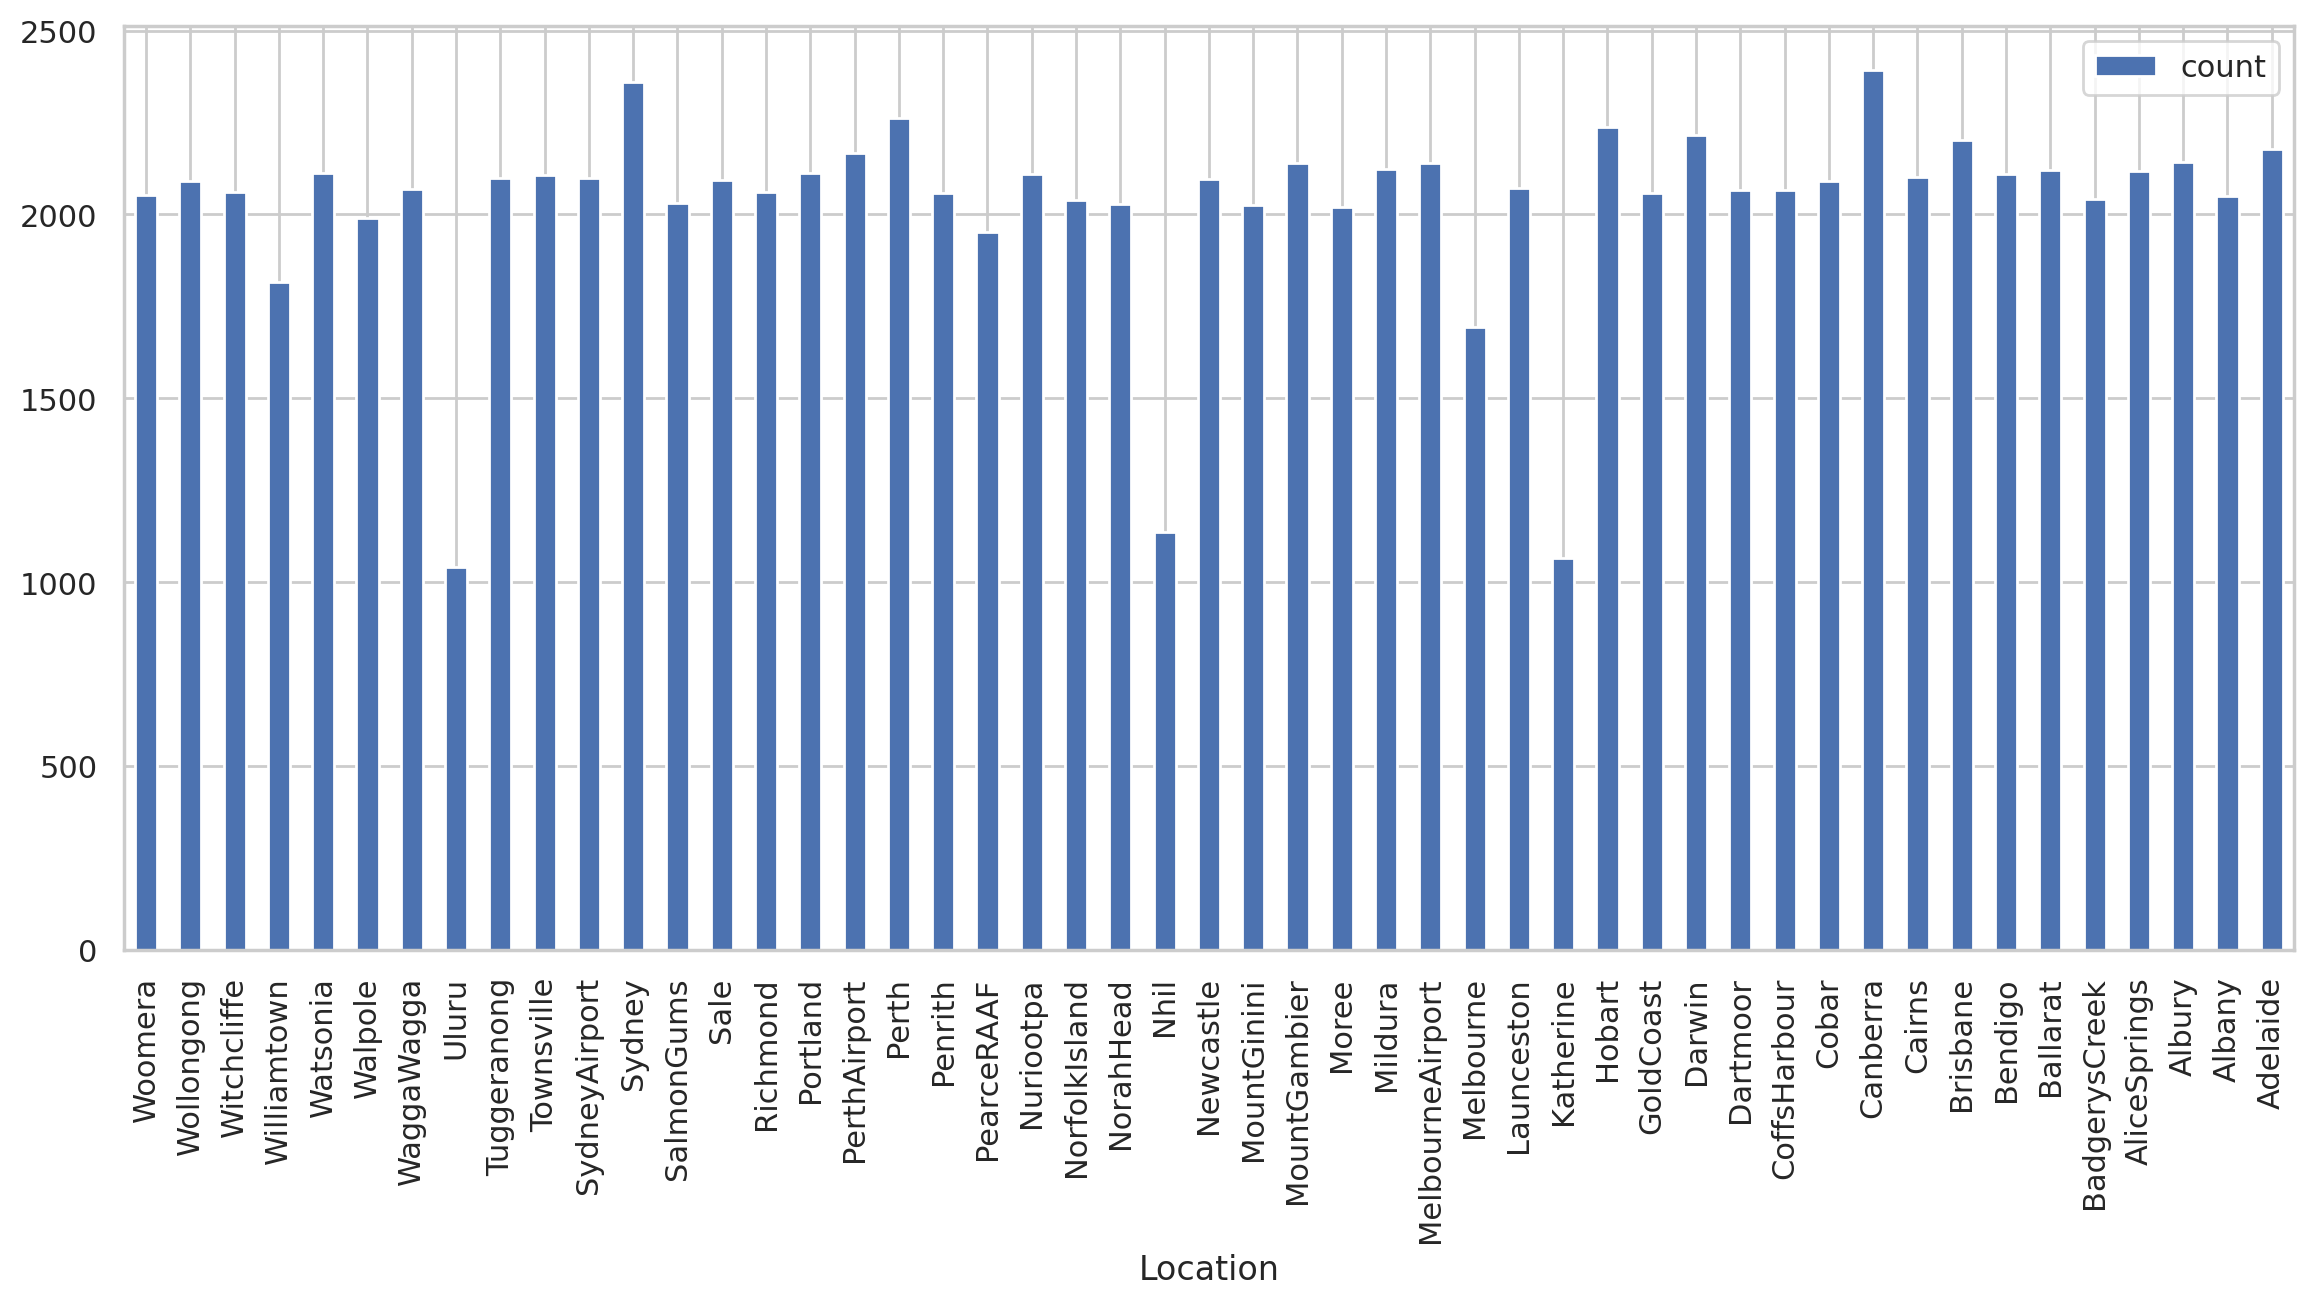

In [26]:
result_df.toPandas().plot.bar(x='Location',figsize=(14, 6))

De esta manera podemos comprobar que no se tiene el mismo número de observaciones para cada ciudad.

# 4. Preprocesamiento de los datos

En este punto no nos interesa trabajar con valores atípicos o con aquellos que faltan. Por lo que buscamos dar unos valores lógicos a aquellos ausentes o bien eliminar ciertas observaciones.

In [27]:
df.count() #Numero de filas

99516

In [28]:
from pyspark.sql.functions import col

# Obtener el recuento de valores nulos para cada columna
nulos_por_columna = {
    columna: df.filter(col(columna).isNull()).count()
    for columna in df.columns
}

# Mostrar los recuentos de valores nulos por columna
for columna, count in nulos_por_columna.items():
    print(f"Cantidad de valores nulos en la columna '{columna}': {count}")

Cantidad de valores nulos en la columna 'RowID': 0
Cantidad de valores nulos en la columna 'Location': 0
Cantidad de valores nulos en la columna 'MinTemp': 443
Cantidad de valores nulos en la columna 'MaxTemp': 230
Cantidad de valores nulos en la columna 'Rainfall': 979
Cantidad de valores nulos en la columna 'Evaporation': 42531
Cantidad de valores nulos en la columna 'Sunshine': 47317
Cantidad de valores nulos en la columna 'WindGusdir': 0
Cantidad de valores nulos en la columna 'WindGuSpeed': 6480
Cantidad de valores nulos en la columna 'WindDir9am': 0
Cantidad de valores nulos en la columna 'WindDir3pm': 0
Cantidad de valores nulos en la columna 'WindSpeed9am': 935
Cantidad de valores nulos en la columna 'WindSpeed3pmm': 1835
Cantidad de valores nulos en la columna 'Humidity9am': 1233
Cantidad de valores nulos en la columna 'Humidity3pm': 2506
Cantidad de valores nulos en la columna 'Preasure9am': 9748
Cantidad de valores nulos en la columna 'Preasure3pm': 9736
Cantidad de valores 

## 4.1 Columnas sin información

Como ya comentabamos al principio de esta libreta se podrían eliminar las columnas con muchos valores ausentes. Sin embargo, se ha optado por no eliminarlos ya que se confia en que aporten información. Sí elimnamos la primera columna.

In [29]:
df = df.drop('RowID')
df

DataFrame[Location: string, MinTemp: float, MaxTemp: float, Rainfall: float, Evaporation: float, Sunshine: float, WindGusdir: string, WindGuSpeed: float, WindDir9am: string, WindDir3pm: string, WindSpeed9am: float, WindSpeed3pmm: float, Humidity9am: float, Humidity3pm: float, Preasure9am: float, Preasure3pm: float, Cloud9am: float, Cloud3pm: float, Temp9am: float, Temp3pm: float, RainToday: string, RainTomorrow: int]

## 4.2. Más arreglos (corregir valores ausentes).

### 4.2.1. Aplicamos la media a las variables numéricas

In [32]:
from pyspark.sql.functions import mean, rand, when

# Obtener el nombre de las columnas numéricas
num_cols = [c for c, dtype in df.dtypes if dtype in ["double", "int", "float"]]

# Calcular el valor medio de cada columna numérica
medias = df.select([mean(c).alias(c) for c in num_cols]).first().asDict()

# Rellenar los valores nulos con la media de cada columna
for col_name in num_cols:
    df = df.fillna(medias[col_name], subset=[col_name])

df.show()

+--------+-------+-------+---------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp| Rainfall|Evaporation| Sunshine|WindGusdir|WindGuSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pmm|Humidity9am|Humidity3pm|Preasure9am|Preasure3pm|Cloud9am| Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+---------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|  Albury|   13.4|   22.9|      0.6|  5.4613194|7.6150904|         W|       44.0|         W|       WNW|        20.0|         24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|4.5191216|   16.9|   21.8|       No|           0|
|  Albury|    7.4|   25.1|      0.0|  5.4613194|7.61

### 4.2.2. Corrección de las variables cualitativas

In [33]:
na_cols = ['WindGusDir','WindDir9am','WindDir3pm'] # Variables cualitativas con NAs
values = ['W', 'NNW', 'ENE', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW', 'SE', 'ESE', 'E', 'NW', 'NNE', 'SW', 'WNW'] # Valores que pueden tomar.

df = df.replace('NA', random.choice(values),subset=na_cols) # Reemplaza los NAs por alguno de los valores posibles de manera aleatoria.
df = df.filter(col("RainToday") != "NA") # i RainToday es NA, elimina la observación.
df.show(10)

+--------+-------+-------+--------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp|Rainfall|Evaporation| Sunshine|WindGusdir|WindGuSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pmm|Humidity9am|Humidity3pm|Preasure9am|Preasure3pm|Cloud9am| Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+--------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|  Albury|   13.4|   22.9|     0.6|  5.4613194|7.6150904|         W|       44.0|         W|       WNW|        20.0|         24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|4.5191216|   16.9|   21.8|       No|           0|
|  Albury|    7.4|   25.1|     0.0|  5.4613194|7.6150904

In [34]:
#Comprobamos cuantos NAs nos quedan, deben de ser 0.
nulos_por_columna = {
    columna: df.filter(col(columna).isNull()).count()
    for columna in df.columns
}
for columna, count in nulos_por_columna.items():
    print(f"Cantidad de valores nulos en la columna '{columna}': {count}")

Cantidad de valores nulos en la columna 'Location': 0
Cantidad de valores nulos en la columna 'MinTemp': 0
Cantidad de valores nulos en la columna 'MaxTemp': 0
Cantidad de valores nulos en la columna 'Rainfall': 0
Cantidad de valores nulos en la columna 'Evaporation': 0
Cantidad de valores nulos en la columna 'Sunshine': 0
Cantidad de valores nulos en la columna 'WindGusdir': 0
Cantidad de valores nulos en la columna 'WindGuSpeed': 0
Cantidad de valores nulos en la columna 'WindDir9am': 0
Cantidad de valores nulos en la columna 'WindDir3pm': 0
Cantidad de valores nulos en la columna 'WindSpeed9am': 0
Cantidad de valores nulos en la columna 'WindSpeed3pmm': 0
Cantidad de valores nulos en la columna 'Humidity9am': 0
Cantidad de valores nulos en la columna 'Humidity3pm': 0
Cantidad de valores nulos en la columna 'Preasure9am': 0
Cantidad de valores nulos en la columna 'Preasure3pm': 0
Cantidad de valores nulos en la columna 'Cloud9am': 0
Cantidad de valores nulos en la columna 'Cloud3pm':

Ya no tenemos NAs. Cambiamos a booleanos las variables sobre si lloverá.

In [35]:
# Casteando a booleanos.
df = df.withColumn("RainToday", df["RainToday"].cast("boolean"))
df = df.withColumn("RainTomorrow", df["RainTomorrow"].cast("boolean"))
df.show(5)

+--------+-------+-------+--------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp|Rainfall|Evaporation| Sunshine|WindGusdir|WindGuSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pmm|Humidity9am|Humidity3pm|Preasure9am|Preasure3pm|Cloud9am| Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+--------+-----------+---------+----------+-----------+----------+----------+------------+-------------+-----------+-----------+-----------+-----------+--------+---------+-------+-------+---------+------------+
|  Albury|   13.4|   22.9|     0.6|  5.4613194|7.6150904|         W|       44.0|         W|       WNW|        20.0|         24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|4.5191216|   16.9|   21.8|    false|       false|
|  Albury|    7.4|   25.1|     0.0|  5.4613194|7.6150904

En este punto tenemos los datos preprocesados, todas las observaciones tienen datos completos y tenemos tanto variables cualitativas como cuantitativas para predecir si al dia siguiente de cada observación lloverá. Por lo que podemos pasar a crear un modelo de predicción.

# 5. Construcción de un modelo de Machine Learning Model con Spark ML


## 5.1. Comprobar la correlación entre las variables.

In [57]:
df_pandas = df.toPandas()

In [58]:
df_pandas.dtypes

Location          object
MinTemp          float32
MaxTemp          float32
Rainfall         float32
Evaporation      float32
Sunshine         float32
WindGusdir        object
WindGuSpeed      float32
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float32
WindSpeed3pmm    float32
Humidity9am      float32
Humidity3pm      float32
Preasure9am      float32
Preasure3pm      float32
Cloud9am         float32
Cloud3pm         float32
Temp9am          float32
Temp3pm          float32
RainToday           bool
RainTomorrow        bool
dtype: object

<Figure size 1200x700 with 0 Axes>

<Axes: >

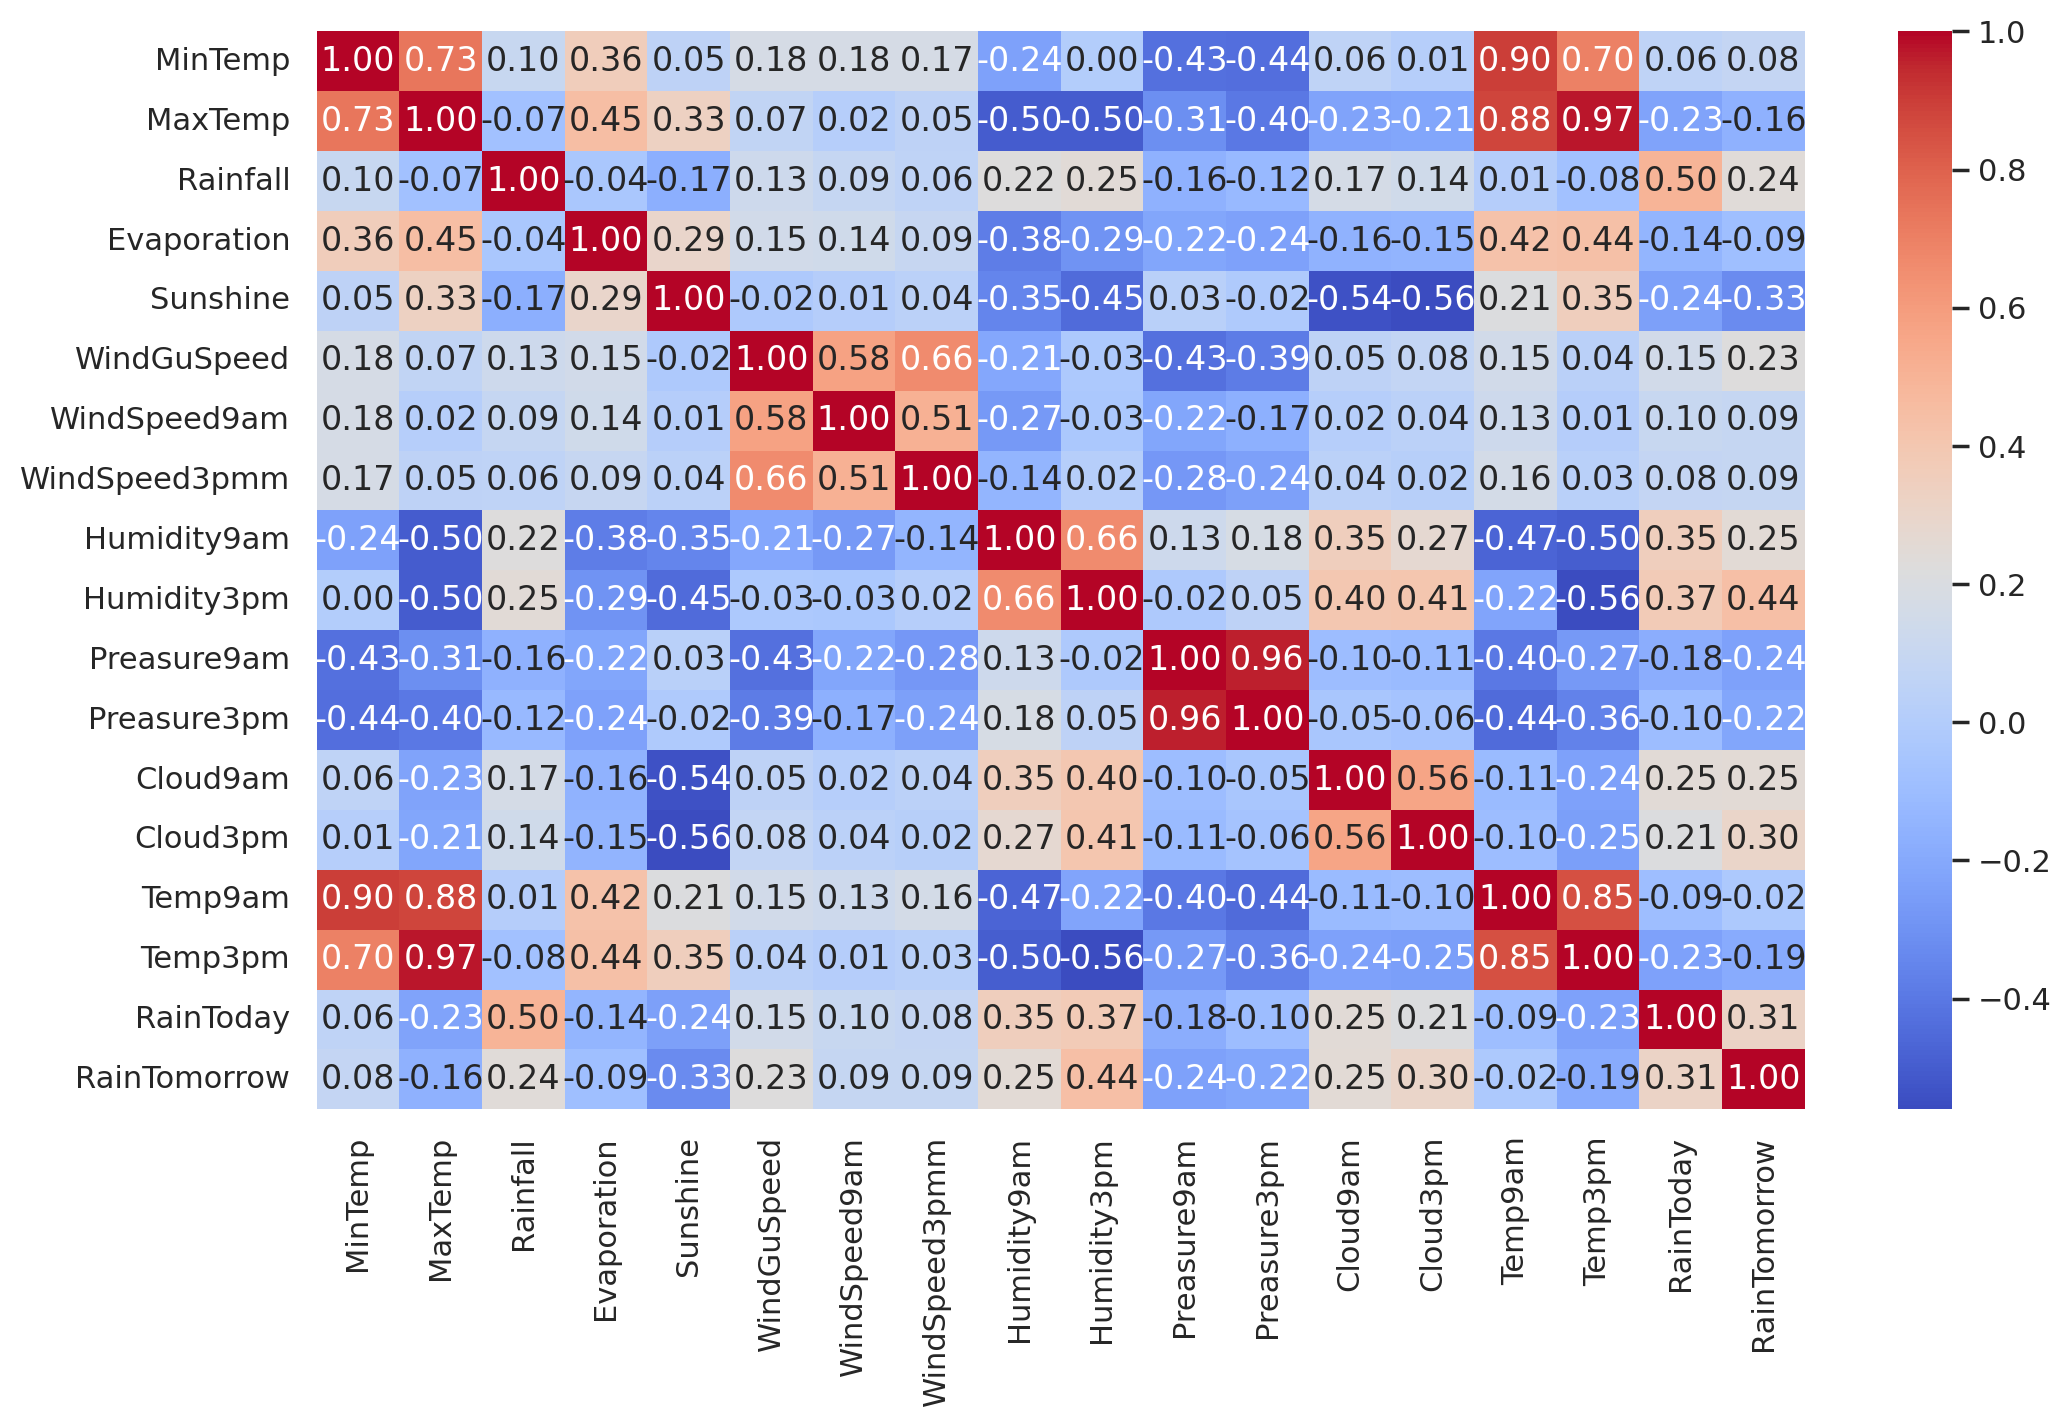

In [59]:
df_num = df_pandas.select_dtypes(include=['float32', 'bool']) # Seleccion de las variables numericas

cor = df_num.corr() # Matriz de correlacion

plt.figure(figsize=(12, 7))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Se puede apreciar gran correlación entre todas las temperaturas, estando la temperatura máxima más correlacionada con la temperatura a las 3 de la tarde y la mínima con la temperatura a las 9 de la mañana.

También está muy altamente correlacionada la presión a las 9am y la presión a las 3pm. Además las variables relacionadas con la velocidad del viento están también muy correlacionadas.

Por otra parte, están inversamente correlacionadas las variables que indican que el cielo está nublado con la variable que indica que hace sol, como es de esperar.

Respecto a nuestra variable objetivo ```RainTomorrow```, con las variables que más intensamente está correlacionada es con la humedad a las 3 de la tarde de forma directa y con el que hecho de que haga sol de forma inversa.



Ahora las variables cualitativas las codificamos aplicando dummies.

In [60]:
columnas_cualitativas = ['Location', 'WindGusdir', 'WindDir9am', 'WindDir3pm']
df_pandas_dummies = pd.get_dummies(df_pandas[columnas_cualitativas])
df_pandas_dummies.head()

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGusdir_E,WindGusdir_ENE,WindGusdir_ESE,WindGusdir_N,WindGusdir_NA,WindGusdir_NE,WindGusdir_NNE,WindGusdir_NNW,WindGusdir_NW,WindGusdir_S,WindGusdir_SE,WindGusdir_SSE,WindGusdir_SSW,WindGusdir_SW,WindGusdir_W,WindGusdir_WNW,WindGusdir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,

In [61]:
df_pandas_dummies = pd.concat([df_pandas.drop(columnas_cualitativas, axis=1), df_pandas_dummies], axis=1)
df_pandas_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGuSpeed,WindSpeed9am,WindSpeed3pmm,Humidity9am,Humidity3pm,Preasure9am,Preasure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGusdir_E,WindGusdir_ENE,WindGusdir_ESE,WindGusdir_N,WindGusdir_NA,WindGusdir_NE,WindGusdir_NNE,WindGusdir_NNW,WindGusdir_NW,WindGusdir_S,WindGusdir_SE,WindGusdir_SSE,WindGusdir_SSW,WindGusdir_SW,WindGusdir_W,WindGusdir_WNW,WindGusdir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.900000,0.6,5.461319,7.61509,44.0,20.0,24.0,71.0,22.0,1007.700012,1007.099976,8.000000,4.519122,16.900000,21.799999,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,7.4,25.100000,0.0,5.461319,7.61509,44.0,4.0,22.0,44.0,25.0,1010.599976,1007.799988,4.447985,4.519122,17.200001,24.299999,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,17.5,32.299999,1.0,5.461319,7.61509,41.0,7.0,20.0,82.0,33.0,1010.799988,1006.000000,7.000000,8.000000,17.799999,29.700001,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,14.6,29.700001,0.2,5.461319,7.61509

In [62]:
#Recolocamos la variable objetivo al final de la lista de variables.
df_pandas_dummies['RainTomorrow'] = df_pandas_dummies.pop('RainTomorrow')
df_pandas_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGuSpeed,WindSpeed9am,WindSpeed3pmm,Humidity9am,Humidity3pm,Preasure9am,Preasure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGusdir_E,WindGusdir_ENE,WindGusdir_ESE,WindGusdir_N,WindGusdir_NA,WindGusdir_NE,WindGusdir_NNE,WindGusdir_NNW,WindGusdir_NW,WindGusdir_S,WindGusdir_SE,WindGusdir_SSE,WindGusdir_SSW,WindGusdir_SW,WindGusdir_W,WindGusdir_WNW,WindGusdir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainTomorrow
0,13.4,22.900000,0.6,5.461319,7.61509,44.0,20.0,24.0,71.0,22.0,1007.700012,1007.099976,8.000000,4.519122,16.900000,21.799999,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,7.4,25.100000,0.0,5.461319,7.61509,44.0,4.0,22.0,44.0,25.0,1010.599976,1007.799988,4.447985,4.519122,17.200001,24.299999,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,17.5,32.299999,1.0,5.461319,7.61509,41.0,7.0,20.0,82.0,33.0,1010.799988,1006.000000,7.000000,8.000000,17.799999,29.700001,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,14.6,29.700001,0.2,5.461319,7.61509

In [63]:
# Pasamos el archivo pandas a spark.
df_final = spark.createDataFrame(df_pandas_dummies)
df_final.show(5)

+------------------+------------------+-------------------+-----------------+-----------------+-----------+------------+-------------+-----------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+---------+-----------------+---------------+---------------+---------------------+----------------------+-----------------+----------------+-----------------+---------------+-----------------+--------------+---------------------+-----------------+---------------+------------------+---------------+------------------+-------------------+------------------+-------------------------+----------------+--------------+---------------------+--------------------+------------------+-------------+------------------+----------------------+------------------+-------------------+----------------+--------------+---------------------+-----------------+-----------------+-------------+-------------------+---------------+-----------------

In [64]:
# Cambiamos la columna objetivo de booleano a entero para el entrenamiento.
df_final = df_final.withColumn("RainTomorrow", col("RainTomorrow").cast("int"))

## 5.2. Partimos el dataset.

In [81]:
# Dividimos los datos en entrenamiento y test
train_data, test_data = df_final.randomSplit([.8,.2], seed=rnd_seed) #Recordamos la semilla era 8
train_data

DataFrame[MinTemp: double, MaxTemp: double, Rainfall: double, Evaporation: double, Sunshine: double, WindGuSpeed: double, WindSpeed9am: double, WindSpeed3pmm: double, Humidity9am: double, Humidity3pm: double, Preasure9am: double, Preasure3pm: double, Cloud9am: double, Cloud3pm: double, Temp9am: double, Temp3pm: double, RainToday: boolean, Location_Adelaide: boolean, Location_Albany: boolean, Location_Albury: boolean, Location_AliceSprings: boolean, Location_BadgerysCreek: boolean, Location_Ballarat: boolean, Location_Bendigo: boolean, Location_Brisbane: boolean, Location_Cairns: boolean, Location_Canberra: boolean, Location_Cobar: boolean, Location_CoffsHarbour: boolean, Location_Dartmoor: boolean, Location_Darwin: boolean, Location_GoldCoast: boolean, Location_Hobart: boolean, Location_Katherine: boolean, Location_Launceston: boolean, Location_Melbourne: boolean, Location_MelbourneAirport: boolean, Location_Mildura: boolean, Location_Moree: boolean, Location_MountGambier: boolean, Loc

In [112]:
# Esta parte es común a todos los modelos.
assembler = VectorAssembler(inputCols=train_data.columns[:-1], outputCol='features') # Definimos las variables independientes y la objetivo.
evaluator = BinaryClassificationEvaluator(labelCol="RainTomorrow", rawPredictionCol="rawPrediction") # Inicializamos el evaluador.

## 5.3. Aplicamos un modelo de Regresión Logística.

In [110]:
# Creamos el modelo`lr`
lr = (LogisticRegression(featuresCol='features', labelCol='RainTomorrow'))

# Lo ajustamos a nuestros datos
lr_model = Pipeline(stages=[assembler, lr]).fit(train_data)

#Aplicamos el modelo a los datos de test
lr_preds = lr_model.transform(test_data)

Logistic Regression Classifier Accuracy:  0.8732290489041793


In [121]:
#Evaluamos el modelo.
lr_score = evaluator.evaluate(lr_preds)
print("Precisión de la clasificación usando Regresión Logística:", lr_score)

Precisión de la clasificación usando Regresión Logística: 0.8732248339778836


Vemos que la accuracy de nuestro modelo es del 87.32%, lo cual es muy positivo.

## 5.4. Random Forest

Como segundo modelo se propone un Random Forest de clasificación.

In [114]:
rf = RandomForestClassifier(numTrees=100, maxDepth=6, labelCol="RainTomorrow", seed=8)
rf_model = Pipeline(stages=[assembler, rf]).fit(train_data)

In [115]:
rf_preds = rf_model.transform(test_data)
rf_score = evaluator.evaluate(rf_preds)
print("Precisión de la clasificación usando Random Forest:", rf_score)

Precisión de la clasificación usando Random Forest: 0.8457972969907569


Al ser la precisión de este modelo 84.58, no mejora la regresión logística, la cual nos daba una precisión del 87.32%.

## 5.5. Árbol de Clasificación.

In [116]:
dt = DecisionTreeClassifier(labelCol="RainTomorrow", featuresCol="features")
dt_model = Pipeline(stages=[assembler, dt]).fit(train_data)

In [118]:
dt_preds = dt_model.transform(test_data)
dt_score = evaluator.evaluate(dt_preds)
print("Precisión de la clasificación usando Arbol de Clasificación:", dt_score)

Decision Tree Classifier accuracy: 0.28676575217582156


Al ser la precisión de este modelo 28.68%, es muy inferior a la precisión obtenida con la regresión logística, por lo que vamos a potenciar este modelo en la siguiente técnica para mejorar esta puntuación.

## 5.6. Gradient-Boosted Tree Classifier (GBTClassifier)

In [119]:
gbt = GBTClassifier(featuresCol='features', labelCol='RainTomorrow', maxIter=10, maxDepth=3)
gbt_model = Pipeline(stages=[assembler, gbt]).fit(train_data)

In [120]:
gbt_preds = gbt_model.transform(test_data)
gbt_score = evaluator.evaluate(gbt_preds)
print('Precision usando el modelo de clasificación Gradient-Boosted:', gbt_score)

Gradient-Boosted Tree Classifier Accuracy: 0.8453900508120861


Vemos que ha mejorado considerablemente la precisión obtenida en el arbol de clasificación creado en el punto 7.4., pero aun está ligeramente por debajo de la precisión obtenida con la regresión logística.

## 5.7. Resumen de las técnicas usadas.

In [122]:
print("Precisión de la clasificación usando Regresión Logística:", lr_score)
print('Precision usando el modelo de clasificación Gradient-Boosted:', gbt_score)
print("Precisión de la clasificación usando Random Forest:", rf_score)
print("Precisión de la clasificación usando Arbol de Clasificación:", dt_score)

Precisión de la clasificación usando Regresión Logística: 0.8732248339778836
Precision usando el modelo de clasificación Gradient-Boosted: 0.8453900508120861
Precisión de la clasificación usando Random Forest: 0.8457972969907569
Precisión de la clasificación usando Arbol de Clasificación: 0.28676575217582156


Por tanto, nos quedamos con el modelo de clasificación usando la regresión logísica, el cual tiene una precisión del 87,32%. En la siguiente tabla podemos analizar de forma más detallada el tipo de error de este modelo.

In [123]:
lr_preds = lr_model.transform(test_data)
lr_preds = lr_preds.select('RainTomorrow', 'prediction')
lr_preds = lr_preds.rdd.map(lambda x: (float(x[1]), float(x[0])))
lr_preds = spark.createDataFrame(lr_preds, ['prediction', 'label'])

lr_preds.groupby('label', 'prediction').count().show()
print("Logistic Regression Classifier Accuracy: ", lr_score)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2211|
|  0.0|       1.0|  854|
|  1.0|       0.0| 2069|
|  0.0|       0.0|14390|
+-----+----------+-----+

Logistic Regression Classifier Accuracy:  0.8732248339778836


Vemos que en el caso de qeu no llueva, label = 0, la clasificación es bastante buena ya que de 15244 observaciones, identifica bien 14390, el 94.40%. Sin embargo, los días que va a llover no los predice tan bien, ya que de 4380 días predice bien 2211, por lo que la precisión en este caso es del 50,48%.

# 6. Parar el Spark

In [ ]:
spark.stop()